In [1]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0.学习任务：

学习anchor和GT目标框的匹配策略

了解并学习损失函数的定义，并思考这样设计的道理

了解在线难例挖掘的训练技巧

- 学习资料

  - [3.5 损失函数](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter03_object_detection_introduction/3_5)

# 1.Matching strategy (匹配策略)：

我们分配了许多prior bboxes，我们要想让其预测类别和目标框信息，我们先要知道每个prior bbox和哪个目标对应，从而才能判断预测的是否准确，从而将训练进行下去。

不同方法 ground truth boxes 与 prior bboxes 的匹配策略大致都是类似的，但是细节会有所不同。这里我们采用SSD中的匹配策略，具体如下：

第一个原则：从ground truth box出发，寻找与每一个ground truth box有最大的jaccard overlap的prior bbox，这样就能保证每一个groundtruth box一定与一个prior bbox对应起来(jaccard overlap就是IOU，如图所示，前面介绍过)。 反之，若一个prior bbox没有与任何ground truth进行匹配，那么该prior bbox只能与背景匹配，就是负样本。

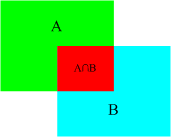

一个图片中ground truth是非常少的，而prior bbox却很多，如果仅按第一个原则匹配，很多prior bbox会是负样本，正负样本极其不平衡，所以需要第二个原则。

第二个原则：从prior bbox出发，对剩余的还没有配对的prior bbox与任意一个ground truth box尝试配对，只要两者之间的jaccard overlap大于阈值（一般是0.5），那么该prior bbox也与这个ground truth进行匹配。这意味着某个ground truth可能与多个Prior box匹配，这是可以的。但是反过来却不可以，因为一个prior bbox只能匹配一个ground truth，如果多个ground truth与某个prior bbox的 IOU 大于阈值，那么prior bbox只与IOU最大的那个ground truth进行匹配。

注意：第二个原则一定在第一个原则之后进行，仔细考虑一下这种情况，如果某个ground truth所对应最大IOU的prior bbox小于阈值，并且所匹配的prior bbox却与另外一个ground truth的IOU大于阈值，那么该prior bbox应该匹配谁，答案应该是前者，首先要确保每个ground truth一定有一个prior bbox与之匹配。

用一个示例来说明上述的匹配原则：

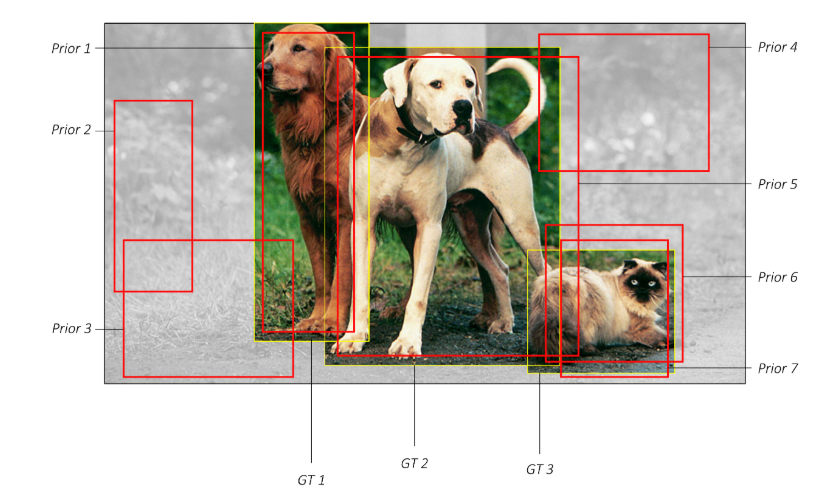

图像中有7个红色的框代表先验框，黄色的是ground truths，在这幅图像中有三个真实的目标。按照前面列出的步骤将生成以下匹配项：



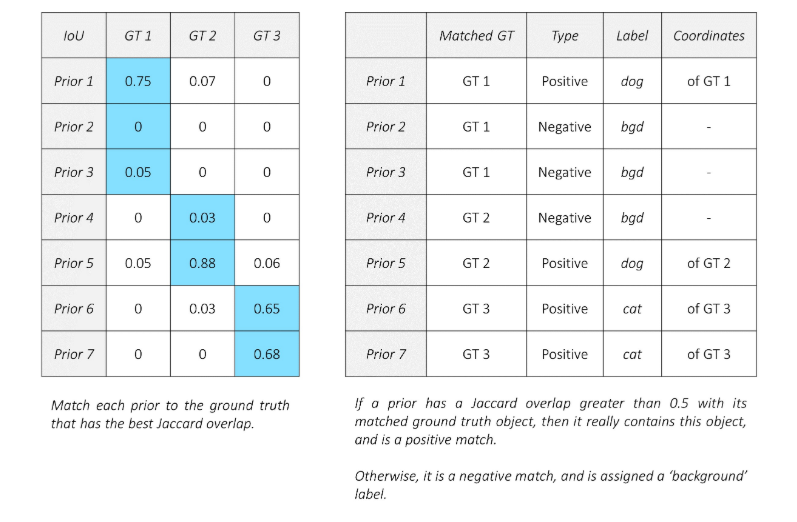

# 2.损失函数

将总体的目标损失函数定义为 定位损失（loc）和置信度损失（conf）的加权和：



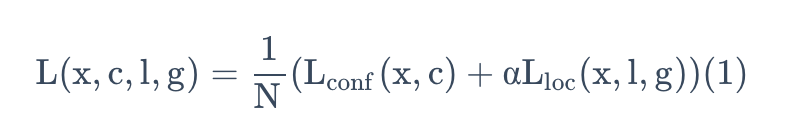

其中N是匹配到GT（Ground Truth）的prior bbox数量，如果N=0，则将损失设为0；而 α 参数用于调整confidence loss和location loss之间的比例，默认 α=1。

confidence loss是在多类别置信度(c)上的softmax loss，公式如下：

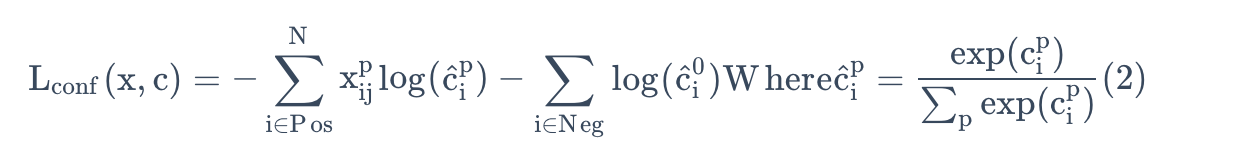

其中i指代搜索框序号，j指代真实框序号，p指代类别序号，p=0表示背景。其中$x^{p}_{ij}=\left\{1,0\right\}	$中取1表示第i个prior bbox匹配到第 j 个GT box，而这个GT box的类别为 p 。$C^{p}_{i}$
  表示第i个搜索框对应类别p的预测概率。此处有一点需要关注，公式前半部分是正样本（Pos）的损失，即分类为某个类别的损失（不包括背景），后半部分是负样本（Neg）的损失，也就是类别为背景的损失。

而location loss（位置回归）是典型的smooth L1 loss

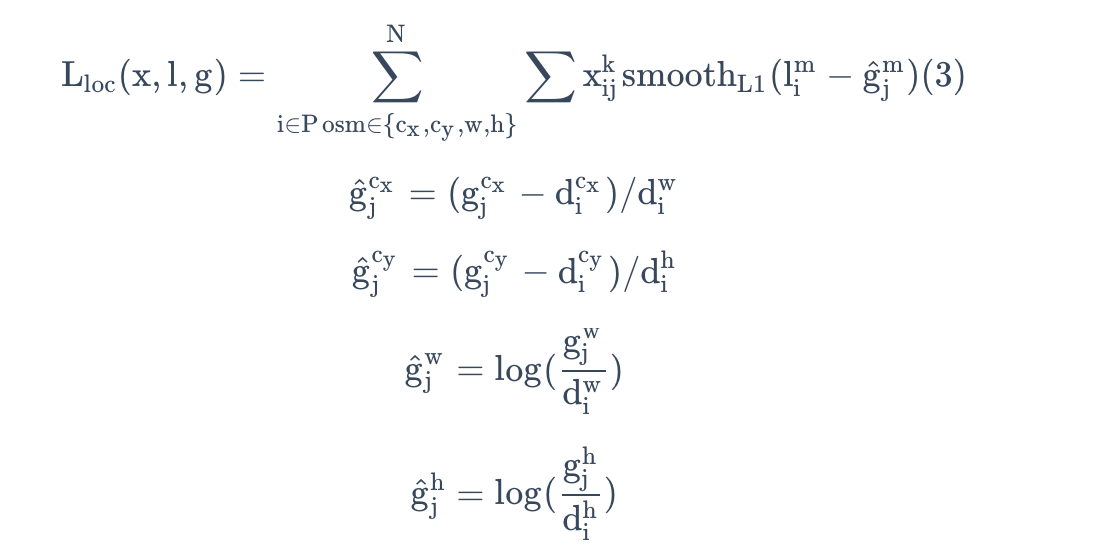

其中，l为预测框，g为ground truth。(cx,xy)为补偿(regress to offsets)后的默认框d的中心,(w,h)为默认框的宽和高。更详细的解释看-看下图：



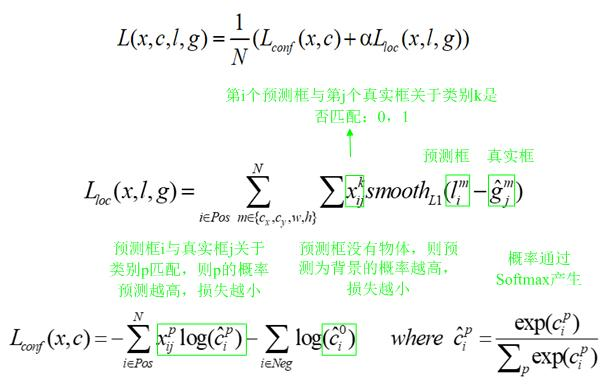

# 3.Hard negative mining:

值得注意的是，一般情况下negative prior bboxes数量 >> positive prior bboxes数量，直接训练会导致网络过于重视负样本，预测效果很差。为了保证正负样本尽量平衡，我们这里使用SSD使用的在线难例挖掘策略(hard negative mining)，即依据confidience loss对属于负样本的prior bbox进行排序，只挑选其中confidience loss高的bbox进行训练，将正负样本的比例控制在positive：negative=1:3。其核心作用就是只选择负样本中容易被分错类的困难负样本来进行网络训练，来保证正负样本的平衡和训练的有效性。

举个例子：假设在这 441 个 prior bbox 里，经过匹配后得到正样本先验框P个，负样本先验框 441−P 个。将负样本prior bbox按照prediction loss从大到小顺序排列后选择最高的M个prior bbox。这个M需要根据我们设定的正负样本的比例确定，比如我们约定正负样本比例为1:3时。我们就取M=3P，这M个loss最大的负样本难例将会被作为真正参与计算loss的prior bboxes，其余的负样本将不会参与分类损失的loss计算。



# 4.小结

本小节介绍的内容围绕如何进行训练展开，主要是3块：

先验框与GT框的匹配策略
损失函数计算
难例挖掘
这3部分是需要结合在一起理解，我们再整个梳理下计算loss的步骤

1）先验框与GT框的匹配

按照我们介绍的方案，为每个先验框都分配好类别，确定是正样本还是负样本。

计算loss
按照我们定义的损失函数计算 分类loss 和 目标框回归loss

负样本不计算目标框的回归loss

难例挖掘
上面计算的loss中分类loss的部分还不是最终的loss

因为负样本先验框过多，我们要按一定的预设比例，一般是1:3，将loss最高的那部分负样本先验框拿出来，其余的负样本忽略，重新计算分类loss

完整loss计算过程的代码见model.py中的 MultiBoxLoss 类。

共勉：这一小节是整个章节中最难理解，也是代码最难啃的部分，坚持就是胜利～